<a href="https://colab.research.google.com/github/ameyaditya/imagesimilarity/blob/master/test1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#imports
import json
from pprint import pprint
from google.colab import auth
from googleapiclient.discovery import build
import io
from googleapiclient.http import MediaIoBaseDownload
import pickle
import zipfile
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import imutils
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
%matplotlib inline

Using TensorFlow backend.


In [0]:
#google authentication
auth.authenticate_user()
drive_service = build('drive', 'v3')

In [0]:
#functions to upload datset from google drive
def _create_file_request(file_id):
    return drive_service.files().get_media(fileId=file_id)


def _download_response_bytes(request, print_progress=False):
    downloaded = io.BytesIO()
    downloader = MediaIoBaseDownload(downloaded, request)
    
    for status in _progbar(downloader):
        if print_progress:
            print("Downloaded {}/{} bytes".format(status.resumable_progress, status.total_size))
  
    downloaded.seek(0)
    return downloaded.read()

  
def _progbar(downloader):
    done = False
    while done is False:
        status, done = downloader.next_chunk()
        yield status


def get_file_id(name):
    return get_matching_files(name)[0]['id']


def move_from_drive_to_disk(file_names, file_destinations):
    for file_name, dest in zip(file_names, file_destinations):
        file_id = get_file_id(file_name)
        print('Downloading file: "{}"'.format(file_name))
        file_bytes = _download_response_bytes(_create_file_request(file_id), print_progress=True)
        with open(dest, "wb") as f:
            f.write(file_bytes)


def load_pickled_files(file_names):
    for name in file_names:
        yield pickle.load(open(name, "rb"))
        

def get_matching_files(name):
    drive_files_response = _download_response_bytes(drive_service.files().list())
    drive_files_response_dict = json.loads(
        drive_files_response.decode('utf-8')
    )
    drive_files_dict = drive_files_response_dict['files']
  
    matching_records = [
        record
        for record in drive_files_dict
        if record['name'] == name
    ]

    no_records = len(matching_records)
    if no_records == 0:
        raise ValueError('no such file: "{}" on your Google Drive'.format(name))
    elif no_records > 1:
        print('warning: multiple matches for file "{}"'.format(name))
    return matching_records

In [5]:
#loading dataset
example_file_name = 'dataset_for_classification.zip'
example_file_id = get_file_id(example_file_name)
move_from_drive_to_disk([example_file_name], ['dataset_for_classification.zip'])
zip_ref = zipfile.ZipFile('dataset_for_classification.zip', 'r')
zip_ref.extractall('dataset_for_classification')
zip_ref.close()

Downloaded 29869710/29869710 bytes


In [0]:
#load training data
path = "dataset_for_classification/dataset_for_classification/train_data"
X_train = []
for files in sorted(os.listdir(path)):
  X_train.append(cv2.imread('{}/{}'.format(path, files)))
#load test data
X_test = []
path = "dataset_for_classification/dataset_for_classification/test_data"
X_test = []
for files in sorted(os.listdir(path)):
  X_test.append(cv2.imread('{}/{}'.format(path, files)))

In [0]:
#dataproprocessing definition
def process_images(copy):
  images = copy
  for i in range(len(images)):
    if images[i].shape[0] > images[i].shape[1]:
      images[i] = imutils.rotate_bound(images[i], 90)
    images[i] = cv2.resize(images[i], (128, 128))
  return images
  
  

In [8]:
#image processing
X_train = np.array(process_images(X_train))
X_test = np.array(process_images(X_test))
X_train = np.reshape(X_train, (-1, 128, 128, 3))
X_test = np.reshape(X_test, (-1, 128, 128, 3))
X_train.shape, X_test.shape

((800, 128, 128, 3), (200, 128, 128, 3))

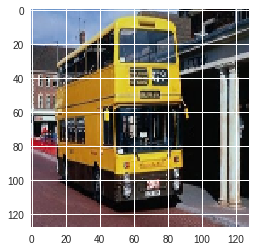

In [9]:
#sample input image
sample1 = X_train[200]
plt.imshow(cv2.cvtColor(sample1.reshape(128, 128, 3), cv2.COLOR_BGR2RGB))

In [10]:
#autoencoder model
input_img = Input(shape=(128, 128, 3))
x = Conv2D(32, (5,5), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(32, (5,5), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(16, (5,5), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2,2), padding='same', name='encode')(x)
#x = Flatten()(x)
#x = Dense(4096, activation='relu')(x)
#x = Dense(1024, activation='relu')(x)
#encoded = Dense(512, activation='relu', name='encode')(x)
#x = Dense(1024, activation='relu')(encoded)
#x = Dense(4096, activation='relu')(x)
#x = Reshape((16,16,16))(x)
x = Conv2D(16, (5,5), activation='relu', padding='same')(encoded)
x = UpSampling2D((2,2))(x)
x = Conv2D(32, (5,5), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
x = Conv2D(32, (5,5), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
decoded = Conv2D(3, (5,5), activation='sigmoid', padding='same')(x)


autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      2432      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        25632     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 16)        12816     
_________________________________________________________________
enco

In [0]:
#scaling the inputs
X_train_fea = X_train.astype('float32')/255
X_test_fea = X_test.astype("float32")/255

In [12]:
#training the autoencoder model
autoencoder.fit(X_train_fea, X_train_fea, epochs=120, batch_size=32)

Instructions for updating:
Use tf.cast instead.
Epoch 1/120
800/800 [==============================] - 111s 139ms/step - loss: 0.0681
Epoch 2/120
800/800 [==============================] - 111s 139ms/step - loss: 0.0340
Epoch 3/120
800/800 [==============================] - 111s 139ms/step - loss: 0.0252
Epoch 4/120
800/800 [==============================] - 112s 140ms/step - loss: 0.0212
Epoch 5/120
800/800 [==============================] - 114s 142ms/step - loss: 0.0200
Epoch 6/120
800/800 [==============================] - 112s 140ms/step - loss: 0.0175
Epoch 7/120
800/800 [==============================] - 111s 138ms/step - loss: 0.0173
Epoch 8/120
800/800 [==============================] - 111s 139ms/step - loss: 0.0164
Epoch 9/120
800/800 [==============================] - 110s 138ms/step - loss: 0.0152
Epoch 10/120
800/800 [==============================] - 110s 138ms/step - loss: 0.0148
Epoch 11/120
800/800 [==============================] - 111s 139ms/step - loss: 0.0148
Epoc

In [0]:
autoencoder.save('autoencoder.h5')
#creating the encoder model
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('encode').output)
encoder.save('encoder.h5')

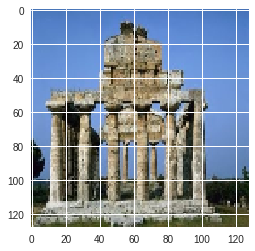

In [41]:
#lets choose a random query image from our test dataset
query_image = X_test_fea[45]
plt.imshow(cv2.cvtColor(query_image.reshape(128,128,3),cv2.COLOR_BGR2RGB))

In [0]:
ans = autoencoder.predict(query_image.reshape(1, 128, 128, 3))

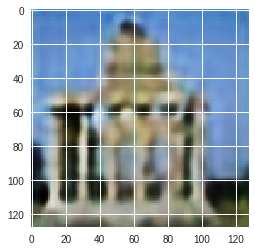

In [43]:
plt.imshow(cv2.cvtColor(ans.reshape(128, 128, 3), cv2.COLOR_BGR2RGB))

In [44]:
#remove the query image from the test model and fit the remaining testdata to our encoder
#X_test_fea = np.delete(X_test_fea, 100, axis = 0)
print("Shape of X_test = ", X_test_fea.shape)
featured_codes = encoder.predict(X_test_fea)
query_code = encoder.predict(query_image.reshape(1, 128, 128, 3))
#query_code = encoder.predict(query_image.reshape(1, 128, 128, 1))
print("Features shape {}, Query Image shape {}".format(featured_codes.shape, query_code.shape))

Shape of X_test =  (200, 128, 128, 3)
Features shape (200, 16, 16, 16), Query Image shape (1, 16, 16, 16)


In [0]:
def plot_closest_images(n, closest_imgs):
  plt.figure(figsize=(20, 6))
  for i in range(n):
      # display original
      ax = plt.subplot(1, n, i+1)
      #plt.imshow(closest_imgs[i].reshape(128, 128, 3), cmap="gray")
      plt.imshow(cv2.cvtColor(closest_imgs[i].reshape(128, 128,3), cv2.COLOR_BGR2RGB))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

  plt.show()

In [0]:
def applying_knn(n, features, query):
  codes_inp = features.reshape(-1, 16*16*16)
  query_inp = query.reshape(-1, 16*16*16)
  nbrs = NearestNeighbors(n).fit(codes_inp)
  dis, ind = nbrs.kneighbors(np.array(query_inp))
  closest_images = X_test[ind]
  closest_images = closest_images.reshape(-1, 128, 128, 3)
  #closest_images = closest_images.reshape(-1, 128, 128)
  plot_closest_images(n, closest_images)

In [0]:
def applying_kmeans(n, features, query):
  codes_inp = features.reshape(-1, 16*16*16)
  query_inp = query.reshape(-1, 16*16*16)
  clf = KMeans(n_clusters = 10)
  clf.fit(codes_inp)
  mydict = {i: np.where(clf.labels_ == i)[0] for i in range(clf.n_clusters)}
  print(mydict)
  images_class = clf.predict(query_inp).tolist()[0]
  print("image class",images_class)
  closest_images = mydict[images_class][:10]
  imgs = [X_test[i] for i in closest_images]
  plot_closest_images(n, imgs)
  

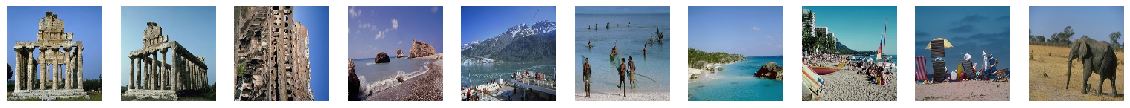

In [48]:
noofrelatedimgs = 10
applying_knn(noofrelatedimgs, featured_codes, query_code)

{0: array([112, 114, 116, 117, 118, 120, 121, 122, 123, 124, 125, 126, 127,
       128, 131]), 1: array([  5,  10,  17,  26,  30,  33,  37,  44,  47,  48,  51,  54,  57,
        65,  68, 132, 157, 159, 161, 165, 166, 169, 170, 172, 174, 175,
       176]), 2: array([67, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 80, 81, 82, 83, 84, 86,
       87, 88, 89]), 3: array([135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 147, 148,
       149, 150, 151, 152, 153, 154, 155]), 4: array([  1,   7,  19,  21,  38,  52,  56,  59,  60,  77,  85, 102, 111,
       113, 129, 130, 133, 134, 146, 158, 164, 167, 180, 183, 186, 191,
       194, 197]), 5: array([  2,   9,  11,  23,  28,  35,  40,  42,  45,  46,  61,  64,  91,
        93,  95,  97,  99, 100, 103, 105, 106, 108, 110, 160, 177]), 6: array([ 22,  32,  43,  94, 101, 104, 115, 179, 181, 182, 184, 185, 187,
       188, 189, 192, 193, 195, 196, 198, 199]), 7: array([ 25,  27,  36,  49,  50,  55,  58,  63,  90,  96, 107, 109, 119]), 8: array([  0, 

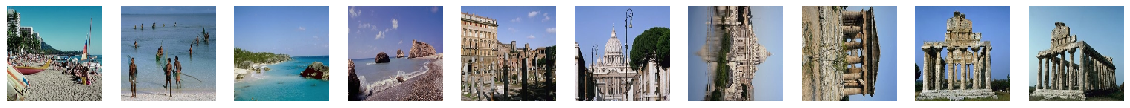

In [49]:
applying_kmeans(noofrelatedimgs, featured_codes, query_code)